# Analyze Box Office Data 
This notebook uses Plotly and Python to apply various graphical techniques using Seaborn to analyze worldwide box office revenue. We will accomplish this with the help of following tasks in the project:

- Data Loading and Exploration
- Visualizing the Target Distribution
- Comparing Film Revenue to Budget
- Do Official Homepages Impact Revenue?
- Distribution of Languages across Films
- Common Words in Film Titles and Descriptions
- How do Film Descriptions Impact Revenue?
- Analyzing Movie Release Dates
- Preprocessing Features
- Create Features Based on Release Date
- Using Plotly to Visualize the Number of Films Per Year
- Number of Films and Revenue Per Year
- Do Release Days Impact Revenue?
- Relationship between Runtime and Revenue

This project uses world-wide box office revenue data collected by [THE MOVIE DB](https://www.themoviedb.org/).

## Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import json
import ast
from urllib.request import urlopen
from PIL import Image

[nltk_data] Downloading package stopwords to /home/bhavya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Loading and Exploration

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,genders_0_crew,genders_1_crew,genders_2_crew,jobs_

## Visualizing the Target Distribution
The target column is the revenue column which holds continuous values. This makes is a regression problem.

We will now look at the distribution of the target variable. This will give insights about the model to be chosen, or if any modifications are required in the data. 

We begin by plotting a histogram of the target variable.

<AxesSubplot:>

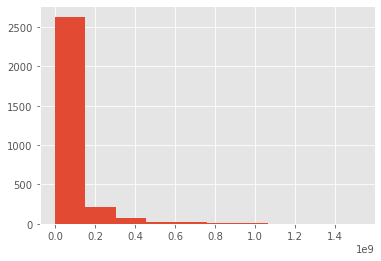

In [4]:
#using pandas
train['revenue'].hist()

Since this is an extremely skewed distribution, we might be able to normalize this by taking logarithm of the distribution. In most regression problems we want the target distribution to be normally distributed so it satisfies the assumptions of regression and the model can perform better at predicting the target.

/home/bhavya/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



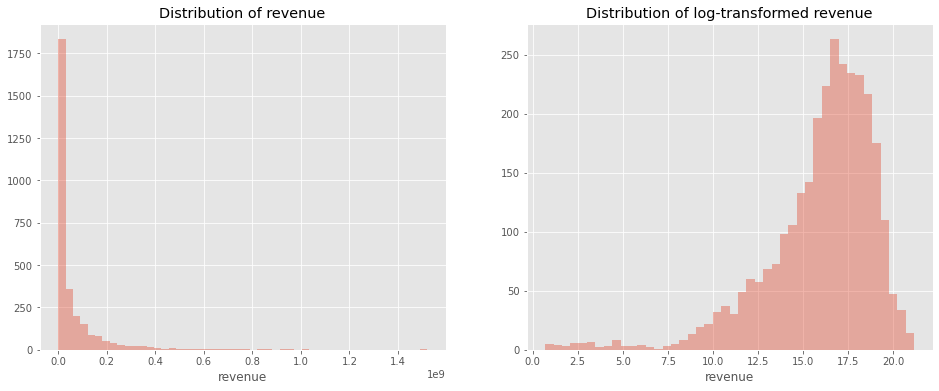

In [5]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1,2,1)
sns.distplot(train['revenue'], kde = False);
plt.title('Distribution of revenue');
plt.subplot(1,2,2)
sns.distplot(np.log1p(train['revenue']), kde = False);
plt.title('Distribution of log-transformed revenue');

In [6]:
train['log_revenue'] = np.log1p(train['revenue'])

## Relationship between Film Revenue and Budget
We plot revenue generated vs film budget to understand the correlation between the two.

/home/bhavya/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='budget', ylabel='revenue'>

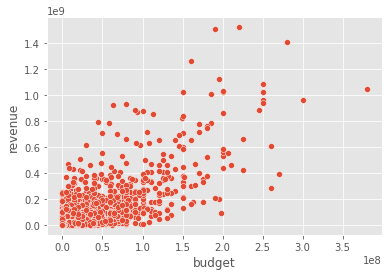

In [7]:
sns.scatterplot(train['budget'], train['revenue'])

Since the relationship is not very evident, we try a logarithmic plot to see if that can give us more insight.

/home/bhavya/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/home/bhavya/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



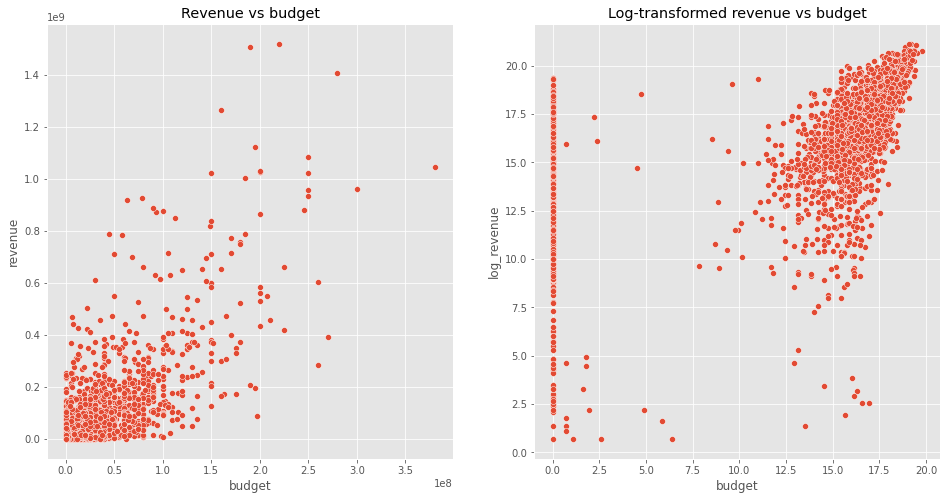

In [8]:
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
sns.scatterplot(train['budget'], train['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1,2,2)
sns.scatterplot(np.log1p(train['budget']), train['log_revenue'])
plt.title('Log-transformed revenue vs budget');

It is evident from the log-transformed graph that there us indeed a correlation between the two variables.

In [9]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

## Does having an Official Homepage Affect Revenue


In [10]:
train['homepage'].value_counts().head

<bound method NDFrame.head of http://www.transformersmovie.com/             4
http://www.lordoftherings.net/                2
http://www.thehobbit.com/                     2
http://burntmovie.com/                        1
https://www.uphe.com/movies/legend-1986       1
                                             ..
http://www.projectalmanac.com/                1
http://www.florencefosterjenkinsmovie.com/    1
http://www.3bahadurmovie.com/                 1
http://www.thewolverinemovie.com              1
http://www.safethefilm.com/                   1
Name: homepage, Length: 941, dtype: int64>

Let us create a binary feature that indicates the presence or absence of a homepage and then plot that against the revenue to see if any correlation exists.

In [11]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

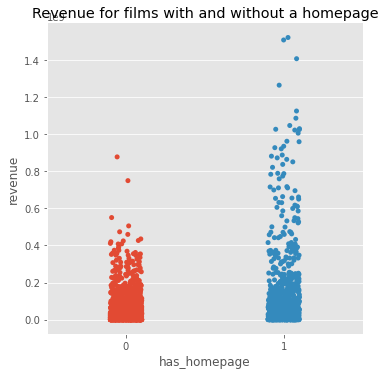

In [12]:
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue for films with and without a homepage');

As we can see, there is a correlation: movies with homepages tend to generate higher revenue.

## Distribution of Languages in Film
Here we see the distribution of languages in films and how they affect revenue. We want to focus on the top 10 occuring languages.

In [13]:
language_data = train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]

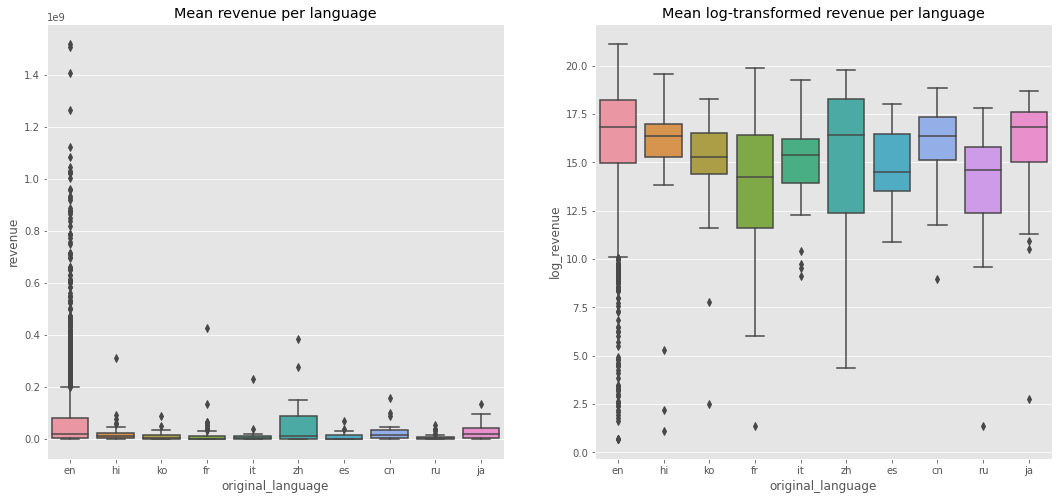

In [14]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
sns.boxplot(x='original_language', y='revenue', data=language_data);
plt.title('Mean revenue per language');
plt.subplot(1,2,2)
sns.boxplot(x='original_language', y='log_revenue', data=language_data);
plt.title('Mean log-transformed revenue per language');

Since there are many more films in English in the dataset, they have a higher range of values in terms of their revenue. However, the subplot on the left can be misleading as it is saying that English overshadows all the other languages but if we see the log transformation, we can observe that films in other languages besides English that also generate high revenue. Although, English is the winner in terms of generating revenue.

## Frequent Words in Film Titles and Descriptions
In this task, we will be creating a word cloud to represent the frequency of words.

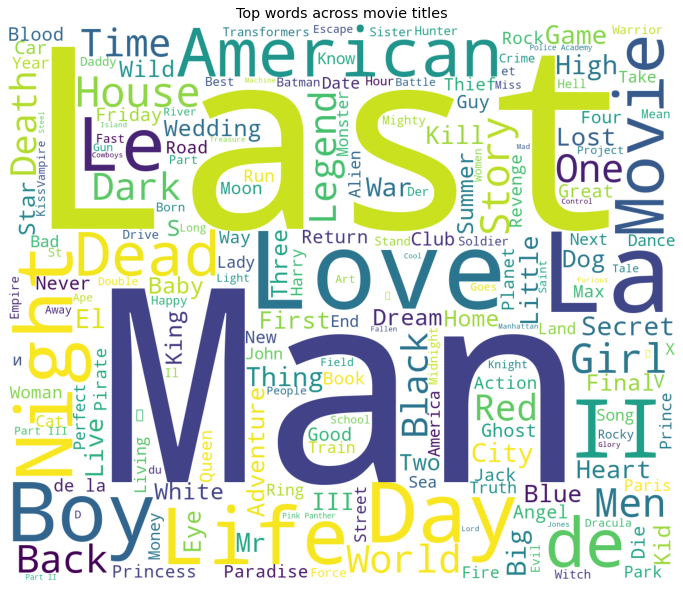

In [15]:
plt.figure(figsize=(12,12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words across movie titles')
plt.axis('off')
plt.show()

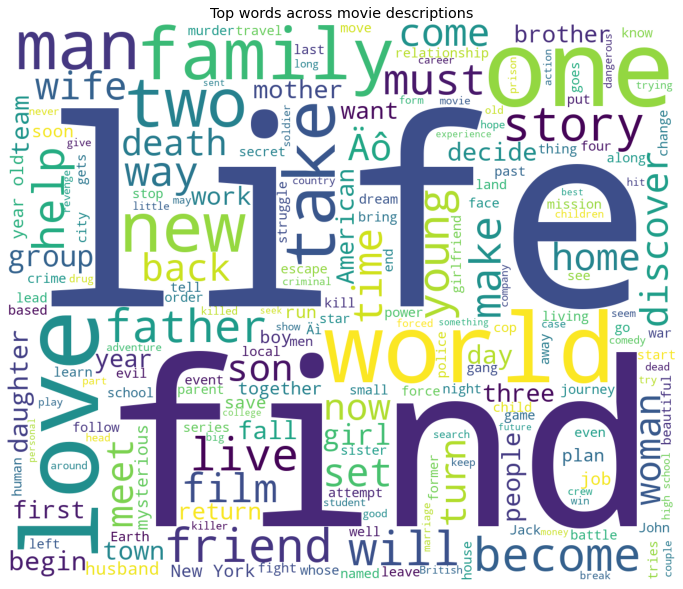

In [16]:
plt.figure(figsize=(12,12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words across movie descriptions')
plt.axis('off')
plt.show()

## Do Film Descriptions Impact Revenue?
We try to find out which words in the film descriptions indicate that the film generates a higher revenue.

How do we fit a linear regression model on String? This is done by creating a tf-idf vector for the words in our corpus. Tf-idf vector helps create a numerical representation for text.

In [17]:
import eli5
from sklearn.linear_model import LinearRegression

In [18]:
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1,2),
    min_df=5
)
overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x!= '<BIAS>')

## Analyzing Movie Release Dates
We need to change the release date to a standard format. The date seems to be in the MM/DD/YY format. Since the dataset contains movies from the 20th century as well as 21st century, we need to clean the year too.

In [19]:
train.loc[train['release_date'].isnull()==False, 'release_date'].head()

0     2/20/15
1      8/6/04
2    10/10/14
3      3/9/12
4      2/5/09
Name: release_date, dtype: object

We check if there are any rows with Nan release dates in the train or test data sets. If there are any, we try if we can fill those if the number is too less.

In [20]:
train.loc[train['release_date'].isnull()==True]

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,genders_0_crew,genders_1_crew,genders_2_crew,jobs_

In [21]:
test.loc[test['release_date'].isnull()==True]

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,genders_0_crew,genders_1_crew,genders_2_crew,jobs_Producer

In [22]:
test.loc[test['release_date'].isnull()==True, 'release_date'] = '05/01/00'

Now we write a function to clean the year.

In [23]:
def fix_date(x):
    year = x.split('/')[2]
    if int(year)<= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

In [24]:
train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x: fix_date(x))

## Creating features based on release date

In [25]:
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [26]:
def process_date(df):
    date_parts = ['year', 'weekday', 'month', 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + '_' + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    return df

train = process_date(train)
test = process_date(test)

<ipython-input-26-6b808c8a80f2>:5: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



## Visualize number of films per year

In [27]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = test['release_date_year'].value_counts().sort_index()

In [28]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

data = [go.Scatter(x=d1.index, y=d1.values, name='train'),
       go.Scatter(x=d2.index, y=d2.values, name='test')]

layout = go.Layout(dict(title = 'Number of films per year',
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Film Count'),
                       ), legend = dict(orientation = 'v'))

py.iplot(dict(data=data, layout=layout))

## Number of Films and Revenue per year

In [29]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].sum()

data = [go.Scatter(x=d1.index, y=d1.values, name='number of films'),
       go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2'),]

layout = go.Layout(dict(title = 'Number of films and total revenue per year',
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Film Count'),
                  yaxis2 = dict(title = 'Total revenue', overlaying='y', side='right'),
                       ), legend = dict(orientation = 'v'))

py.iplot(dict(data=data, layout=layout))

In [30]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].mean()

data = [go.Scatter(x=d1.index, y=d1.values, name='number of films'),
       go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2'),]

layout = go.Layout(dict(title = 'Number of films and mean revenue per year',
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Film Count'),
                  yaxis2 = dict(title = 'Mean revenue', overlaying='y', side='right'),
                       ), legend = dict(orientation = 'v'))

py.iplot(dict(data=data, layout=layout))

## Do release days impact revenue?

Text(0.5, 1.0, 'Revenue on different days of the week')

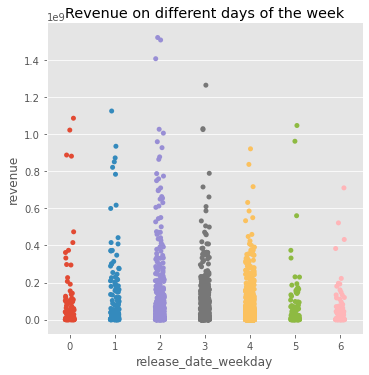

In [31]:
sns.catplot(x='release_date_weekday', y='revenue', data=train);
plt.title('Revenue on different days of the week')

## Relationship between runtime and revenue

/home/bhavya/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



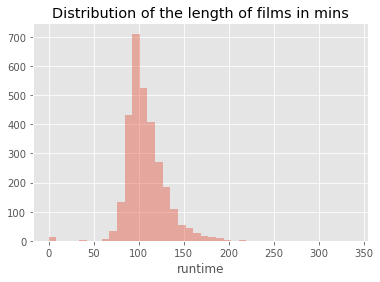

In [32]:
sns.distplot(train['runtime'].fillna(0), bins=40, kde=False);
plt.title('Distribution of the length of films in mins');

/home/bhavya/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'runtime vs revenue')

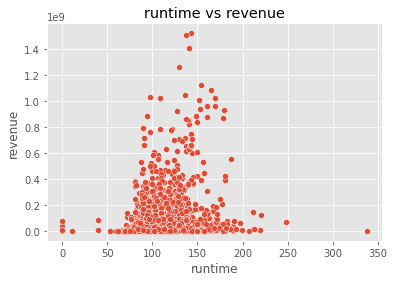

In [33]:
sns.scatterplot(train['runtime'].fillna(0), train['revenue']);
plt.title('runtime vs revenue')